In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import snntorch as snn

Matplotlib created a temporary cache directory at /tmp/matplotlib-97lfgeyy because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [67]:
np.random.seed(0)

In [1]:
# experiment 2
# passive controlled rotation of the head-fixed animal
# controlled rotation of visual flow
# controlled coupling between rotaiton and visual flow

# what type of reflex will be engaged? OKR, VOR? Saccade and fixate?
# OKR - head stationary, world moving around you, eyes follow the world
# VOR - world stationary, head turning, eye move to stabilise at the world

# in perfect coupling scenario OKR + VOR cancel out? Gaze is always straight ahead

# inject noise in self-generated eye movements - to model occasional exploratory movements?
# reset saccades when they go out of arbitrary range for physiological accuracy

In [2]:
# bottom-up inputs - sensory
# w_vest: vestibular angular velocity (+/- CW/CCW) [deg/sec]
# m_flow: magnitude (velocity) of visual flow [deg/sec]

In [3]:
# top-down inputs - self-generated movement
# w_self: self-generated angular rotation [deg/sec]

In [4]:
# outputs
# m_eye: magnitude (velocity) of eye movement [deg/sec]
# influencing visual flow m_flow

# perceived_m_flow = m_flow - m_eye

/tmp/ipykernel_213320/868963982.py:4: RankWarning: Polyfit may be poorly conditioned
  p = np.poly1d(np.polyfit(np.arange(len(random_signal)), random_signal, degree)) # find a polynomial of the same degree to fit the random signal exactly and create a poly1d function out of it


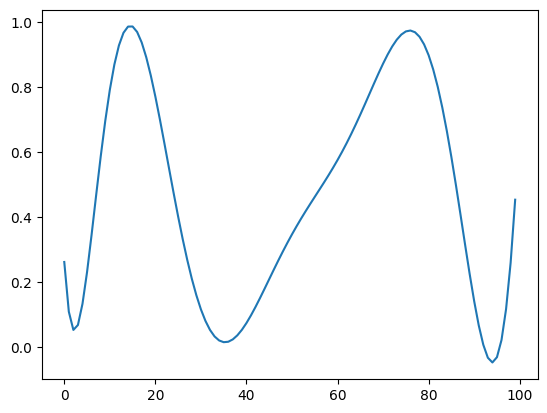

In [268]:
degree = 10
# random_signal = np.random.randn(degree)
random_signal = np.random.random(degree)
p = np.poly1d(np.polyfit(np.arange(len(random_signal)), random_signal, degree)) # find a polynomial of the same degree to fit the random signal exactly and create a poly1d function out of it
# p = np.poly1d(z)
x = np.linspace(0,degree-1,100) # create more points within the fitted range (end-1) to evaluate the polynomial function at -> get a smooth signal
w_vest = p(x)
plt.plot(np.arange(len(w_vest)), w_vest)
plt.show()

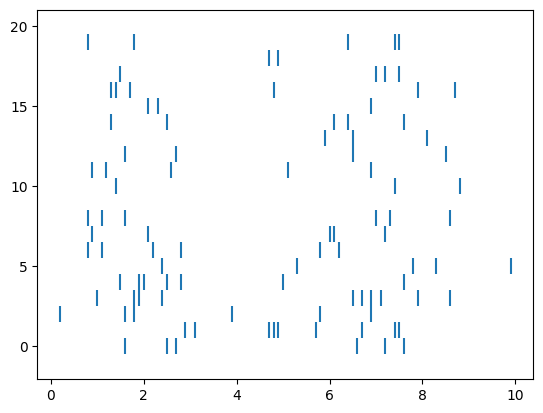

In [274]:
# Poisson FR generator
# Source: https://github.com/btel/python-in-neuroscience-tutorials/blob/master/poisson_process.ipynb

def inhomogeneous_poisson(rate, bin_size):
    n_bins = len(rate)
    spikes = np.random.rand(n_bins) < rate * bin_size
    spike_times = np.nonzero(spikes)[0] * bin_size
    return spike_times

def inhomogeneous_poisson_generator(n_trials, rate, bin_size):
    for i in range(n_trials):
        yield inhomogeneous_poisson(rate, bin_size)

spike_times = list(inhomogeneous_poisson_generator(n_trials=20, rate=w_vest, bin_size=0.1))

plt.eventplot(spike_times)
plt.show()

In [ ]:
# Network setup

In [286]:
# preliminary goal of the network:
# to produce eye movement signal that will stabilise visual flow
# given perceived visual flow & vestibular rotation
# first test with coupling = 1
# then, during training vary coupling

In [283]:
time_step = 1e-3
# nb_steps  = 200

# two bottom up inputs (no self-generated motion in experiment 2)
nb_inputs = 2
nb_hidden = 10
nb_outputs = 1


device = torch.device("cuda:0")
dtype = torch.float

In [284]:
tau_mem = 10e-3
# tau_syn = 5e-3

# alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [285]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

tensor([[ 0.5708, -0.5316,  0.2581,  0.5026, -1.4604,  0.8854,  0.0088,  0.0968,
         -0.5203, -0.0094],
        [ 0.0368, -0.6062,  0.0075,  0.2377,  0.2070,  0.7511,  0.6805, -0.1783,
          0.1473, -0.2075]], device='cuda:0', requires_grad=True)